In [ ]:
import random
import pandas as pd
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

In [ ]:
"""
Separate each asset to independent df
"""

raw_data = pd.read_csv("AIDX.csv", encoding='gbk')

# grouped by index code
grouped_asset = raw_data.groupby("S_IRDCODE")

# only keep dataframe that has more than 200 trading dates
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 200}

# save each asset independently to csv
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)
    # grouped_df.to_csv(f"assets/{ird_code}.csv", index=False)

In [36]:
"""
Find the turning point for a df
"""

# my self-defined strategy
def find_turning_point_self(df, direction, n_days=7, fraction_movement=0.01, threshold_day=14, threshold_rate=0.05):
    df = df.reset_index(drop=True)
    record = []
    
    i = 0  # start index
    while i < len(df.index):
        record_i = i
        pattern_find = False
        for n in range(1, n_days+1):
            try:
                current_close = df.loc[i, 'CLOSE']
                ndays_close = df.loc[i+n, 'CLOSE']
                if (ndays_close - current_close) * direction >= (fraction_movement * current_close):
                    pattern_find = True
                    i += n
                    n = 0
            except:
                pass
        if pattern_find:
            start_date = df.loc[record_i, 'TRADE_DT']
            end_date = df.loc[i, 'TRADE_DT']
            start_close = df.loc[record_i, 'CLOSE']
            end_close = df.loc[i, 'CLOSE']
            if (i - record_i) >= threshold_day \
                or (end_close - start_close) * direction >= (threshold_rate * start_close):
                # print(f"Direction: {direction}, Start: {start_date}, End: {end_date}")
                record.append((start_date, end_date))
            else:
                i = record_i
        i += 1
    return record

# moving average strategy
def find_turning_point_ma(df, window_size=30, threshold=0.05, days_after=0):
    df['moving_average'] = df['CLOSE'].rolling(window=window_size).mean()
    df['deviation'] = ((df['CLOSE'] - df['moving_average']) / df['moving_average']).abs()
    df['is_significant_turning_point'] = df['deviation'] > threshold
    significant_turning_points = df[df['is_significant_turning_point']]

    turning_point_periods = []
    for index, row in significant_turning_points.iterrows():
        start_date = row['TRADE_DT']
        current_index = df.index.get_loc(index)
        end_index = min(current_index + days_after, len(df) - 1)
        end_date = df.iloc[end_index]['TRADE_DT']
        turning_point_periods.append((start_date, end_date))

    return turning_point_periods

# hull moving average strategy
def find_turning_point_hma(df, period=30, days_after=0):
    def weighted_moving_average(data, period):
        weights = np.arange(1, period+1)
        return data.rolling(period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    
    def hull_moving_average(data, period):
        sqrt_period = int(np.sqrt(period))
        wma_2x = weighted_moving_average(data, period // 2)*2
        wma = weighted_moving_average(data, period)
        raw_hma = wma_2x - wma
        hma = weighted_moving_average(raw_hma, sqrt_period)
        return hma
    
    df['HMA'] = hull_moving_average(df['CLOSE'], period)
    df['hma_change'] = df['HMA'].diff()
    df['hma_direction_change'] = df['hma_change'].apply(np.sign).diff().ne(0)
    turning_points = df[df['hma_direction_change']]
    
    turning_point_periods = []
    for index, row in turning_points.iterrows():
        start_date = row['TRADE_DT']
        current_index = df.index.get_loc(index)
        end_index = min(current_index + days_after, len(df) - 1)
        end_date = df.iloc[end_index]['TRADE_DT']
        turning_point_periods.append((start_date, end_date))
    
    return turning_point_periods


In [ ]:
"""
Visualisation
"""

def asset_whole_period_visualisation(ird_code, df, date_record, window_size=30):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plotting the moving average
    df['moving_average'] = df['CLOSE'].rolling(window=window_size).mean()
    ax.plot(df['TRADE_DT'], df['moving_average'], label='Moving Average', color='orange', linestyle='--')
    
    line, = ax.plot(df['TRADE_DT'], df['CLOSE'], marker='o',  label='Close Price')
    
    # Special part hightlight
    for start_date, end_date in date_record:
        mask = (df['TRADE_DT'] >= start_date) & (df['TRADE_DT'] <= end_date)
        segment = df.loc[mask]
        ax.plot(segment['TRADE_DT'], segment['CLOSE'], marker='o', color='red', label='Highlighted Period')

    # Title and labels
    ax.set_title(f'{ird_code}')
    ax.set_xlabel('Trade Date')
    ax.set_ylabel('Close Value')
    ax.grid(True)
    plt.xticks(rotation=45)  # Rotate dates for better visibility

    # Annotation for data cursor
    annot = ax.annotate("", xy=(0,0), xytext=(-20,20),
                        textcoords="offset points", 
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        date = pd.to_datetime(x[ind["ind"][0]]).strftime('%Y-%m-%d')
        text = f"{date}, {y[ind['ind'][0]]:.2f}"
        annot.set_text(text)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)
    
    # Avoid duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()
    return

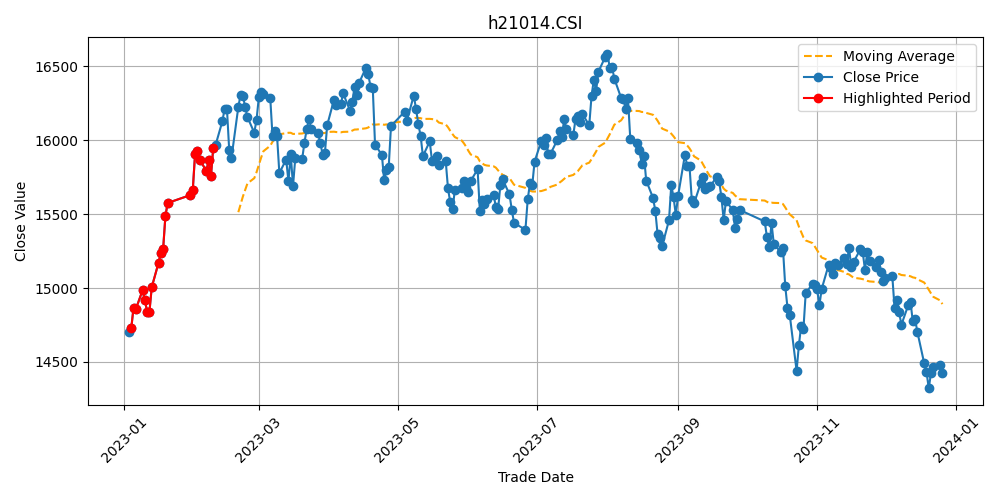

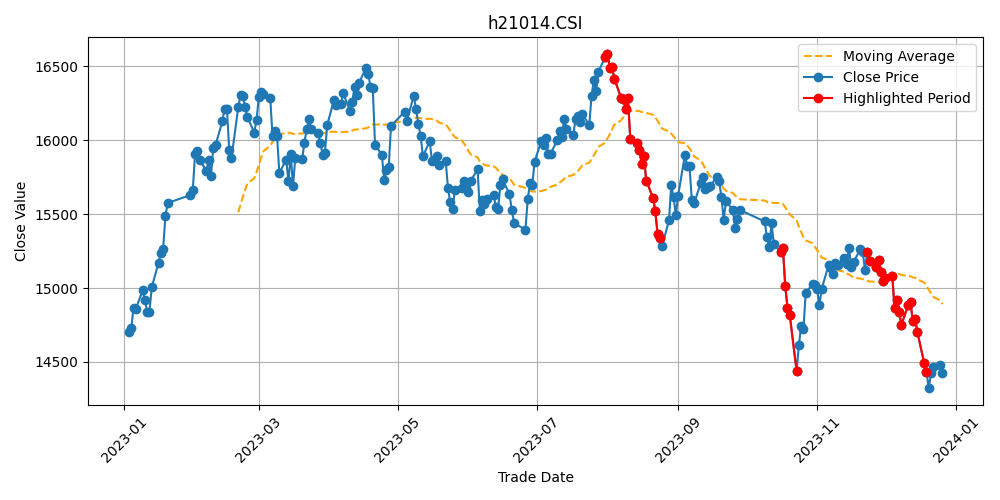

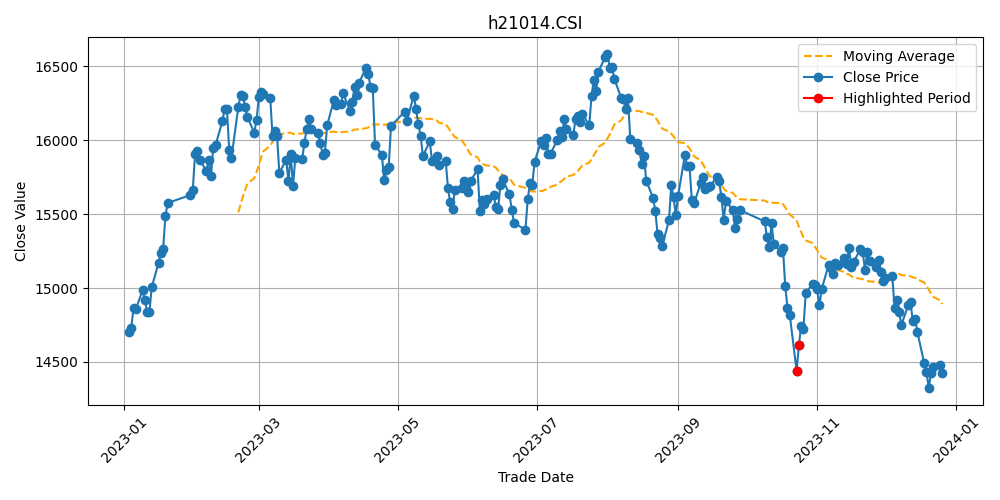

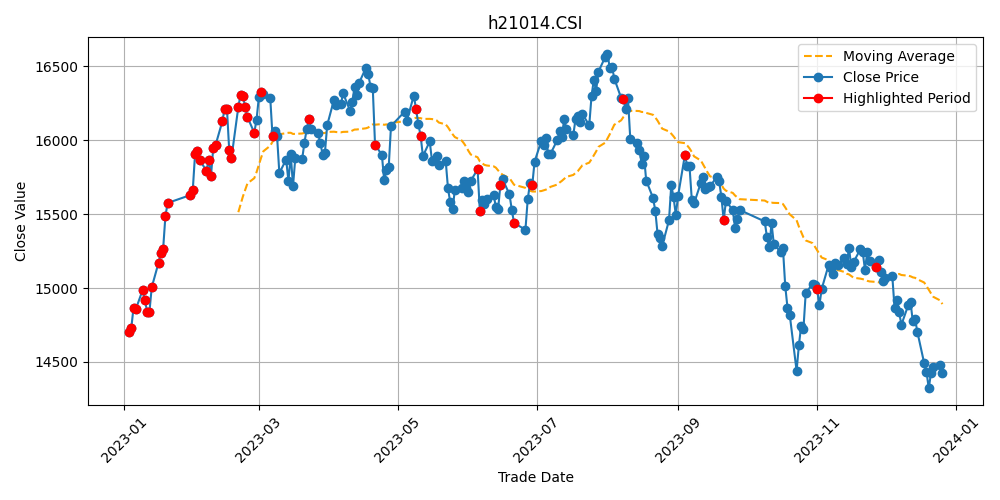

In [38]:
ird_codes = list(asset_dfs.keys())  # Get all the ird_code from the keys of the dictionary
ird_code = random.choice(ird_codes)  # Randomly select one ird_code
ird_code = 'h21014.CSI'
df = asset_dfs[ird_code]

date_record_self_up = find_turning_point_self(df, direction=1, fraction_movement=0.01, threshold_day=22, n_days=7)
asset_whole_period_visualisation(ird_code, df, date_record=date_record_self_up)

date_record_self_down = find_turning_point_self(df, direction=-1, fraction_movement=0.01, threshold_day=22, n_days=7)
asset_whole_period_visualisation(ird_code, df, date_record=date_record_self_down)

date_record_ma = find_turning_point_ma(df)
asset_whole_period_visualisation(ird_code, df, date_record=date_record_ma)

date_record_hma = find_turning_point_hma(df)
asset_whole_period_visualisation(ird_code, df, date_record=date_record_hma)